<a href="https://colab.research.google.com/github/sravanisasu/CleanGreen/blob/master/hari_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
# General
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pyplot as plt 
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import weight_norm
from torch.nn.parallel import DistributedDataParallel as DDP
# Scikit Learn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import minmax_scale
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

np.random.seed(2)

In [107]:
# Morlet Function
def w_func(t):
  return torch.cos(1.75*t)* torch.exp(-(t**2))

In [108]:
batch_size= 32
lr = 0.001
mom = 0.999
epochs=500
filename = 'ObesityDataSet_raw_and_data_sinthetic.csv'
data = pd.read_csv(filename)
nin = len(data.columns)-1 # Size of input layer (sample size, number of features) 
nhn = 10 # Size of hidden layer
non = 1

In [109]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = weight_norm(nn.Linear(nin, nhn, bias=False))
        self.fc2 = weight_norm(nn.Linear(nhn, non, bias=False))
        self.a = nn.Parameter(torch.rand(nhn), requires_grad=True)
        self.b = nn.Parameter(torch.rand(nhn), requires_grad=True)

    def forward(self, x):
        t = (self.fc1(x)-self.b)/self.a
        vk = self.fc2(w_func(t))
        return vk



In [110]:
class CustomDataset(Dataset):
    def __init__(self, x,y):
        self.data = []
        for i,j in zip(x,y):
            self.data.append((i,j))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @classmethod 
    def splits(cls, filename):
        
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        data = pd.read_csv(filename)
        #numeric_columns = data.select_dtypes(include=numerics)
        cols_name = data.loc[:, data.dtypes == object].columns
        data = data.replace("?","NaN")
        data.fillna(data.mean())
        for col_name in cols_name:
            list_total = list(data[col_name])
            list_uniq = list(set((list_total)))
            data[col_name] = [list_uniq.index(data)+1 for data in list_total]
        # Normalizing Data
        data[data.columns] = minmax_scale(data[data.columns])
        #data.to_csv(filename_p)
        #print('\n-------  DataFrame after normalization and encoding -------\n')
        #print(data_raw[0])
        #print(data_raw.shape)
        data_pre = np.array(data)
        x=data_pre[:,:-1]
        y=data_pre[:,-1]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
        y_train=  torch.from_numpy(np.expand_dims(y_train, axis=1)).float()
        y_test=  torch.from_numpy(np.expand_dims(y_test, axis=1)).float()
        x_train =  torch.from_numpy(x_train).float()
        x_test =  torch.from_numpy(x_test).float()
        # print(x_train[0].shape,y_train[0].shape)
        # print(x_train[1].shape,y_train[1].shape)
        train = cls(x_train, y_train)
        test = cls(x_test, y_test)
        return train, test

In [111]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [112]:
start_time = time.time()

model = Net()
loss = 0
losses = AverageMeter()
total_loss = 0
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=mom)
train, test = CustomDataset.splits(filename)
# t = torch.utils.data.Subset(train, [0])
# print(t)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True, num_workers=2)
loss_array = []
model.train()
for epoch in range(epochs):
    # print("epoch")
    # print(train[2].shape)
    for x,y in train_loader:
        if torch.cuda.is_available():
            x = x.to('cuda')
            y = y.to("cuda")
            model.to('cuda')
        optimizer.zero_grad()
        pred = model(x)
        loss = nn.MSELoss()(pred, y)
        total_loss += loss
        loss.backward()
        optimizer.step()
        losses.update(loss.item())
    loss_array.append(losses.val)
    print_str = 'Epoch: [{0}]\t' \
        'Loss= {loss.val:.6f} \
          Loss Avg: ({loss.avg:.6f})\t' \
        .format(epoch, loss=losses) 
    print(print_str)

end_time = time.time()
print('\n')
print(end_time-start_time)
# print(loss_array)

Epoch: [0]	Loss= 0.147487           Loss Avg: (0.194377)	
Epoch: [1]	Loss= 0.122786           Loss Avg: (0.162897)	
Epoch: [2]	Loss= 0.069455           Loss Avg: (0.140748)	
Epoch: [3]	Loss= 0.092729           Loss Avg: (0.127422)	
Epoch: [4]	Loss= 0.074723           Loss Avg: (0.119625)	
Epoch: [5]	Loss= 0.064465           Loss Avg: (0.114826)	
Epoch: [6]	Loss= 0.074452           Loss Avg: (0.110438)	
Epoch: [7]	Loss= 0.081436           Loss Avg: (0.106709)	
Epoch: [8]	Loss= 0.095197           Loss Avg: (0.103580)	
Epoch: [9]	Loss= 0.065487           Loss Avg: (0.101024)	
Epoch: [10]	Loss= 0.084348           Loss Avg: (0.098724)	
Epoch: [11]	Loss= 0.073664           Loss Avg: (0.096650)	
Epoch: [12]	Loss= 0.080341           Loss Avg: (0.094873)	
Epoch: [13]	Loss= 0.080863           Loss Avg: (0.093197)	
Epoch: [14]	Loss= 0.093252           Loss Avg: (0.091584)	
Epoch: [15]	Loss= 0.081580           Loss Avg: (0.089989)	
Epoch: [16]	Loss= 0.051908           Loss Avg: (0.088696)	
Epoch: 

In [113]:
model.eval()
test_loss = 0
losses = AverageMeter()
y_true = []
y_pred = []
for x,y in test_loader:
    # print(x.tolist(), y.shape)
    if torch.cuda.is_available():
        x = x.to('cuda')
        y = y.to("cuda")
    with torch.no_grad():
      pred = model(x)
      test_loss += nn.MSELoss()(pred, y)
      losses.update(loss.item())
      y = y.cpu()
      pred = pred.cpu()
      for y_d in y:
        y_true.append(y_d.item())
      for pred_d in pred:
        y_pred.append(pred_d.item())
print_str = 'Loss: {loss.val:.6f}\
             Loss Avg: ({loss.avg:.6f})\t' \
             .format(loss=losses) 
print(print_str)
# y_true = np

Loss: 0.021593             Loss Avg: (0.021593)	


In [114]:
r2_score(y_true, y_pred)

0.8746242099733068

In [115]:
mean_absolute_error(y_true, y_pred)

0.0836277668734233

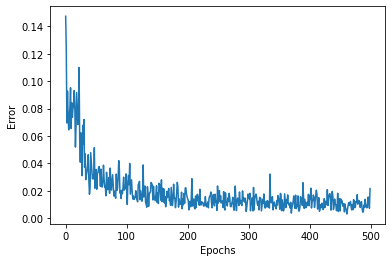

In [116]:
plt.plot(loss_array)
plt.xlabel('Epochs'); 
plt.ylabel('Error');